In [181]:
import matplotlib.pyplot as plt
import numpy as np

In [183]:
import torch
import pytorch_lightning as pl
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import TensorBoardLogger
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [185]:
from transforms import t_get_O
from transforms import get_split_masks
from transforms import get_pair_split_masks
from transforms import config_RG_masks
from Data import MY_Dataset
from flows.NormalizingFlow import NormalizingFlow    
from flows.RGflows import RGflows    
from obs import G, calc_Loss, calc_psi2, gen_fun_W


def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

set_random_seed(42)





In [187]:
from systems.Pot.circle import Circle
from systems.Pot.power import Power
from systems.Pot.sum_power import Sum_power

In [189]:
DIM=16
circ = Circle(1,DIM,g=1,x0=4)
pow = Power(1,DIM,g=1,p=4)
spow = Sum_power(1,DIM,g=1,p=4)

In [191]:
from samplers.Langevin import Langevin
N_samp=20000
z=torch.normal(mean=torch.zeros(N_samp,1,DIM), std=torch.ones(N_samp,1,DIM))
L=Langevin(pow,N_samp,eps=0.0001,N_sweep=1000,log_per=1000)
L.run(z)

tensor([[[ 0.7045,  0.4974,  0.3357,  ..., -0.0738, -0.3854,  0.4743]],

        [[ 0.4806, -0.6998, -0.0696,  ..., -0.0853,  0.1467,  0.2974]],

        [[-0.0287,  0.1198, -0.2924,  ...,  0.5534, -0.4723,  0.3385]],

        ...,

        [[ 0.4598, -0.0665,  0.1036,  ...,  0.4994, -0.0342, -0.7610]],

        [[-0.2755,  0.8762, -0.2586,  ...,  0.0754,  0.2051,  0.4306]],

        [[-0.0542,  0.5655,  0.0481,  ..., -0.3306,  0.0788, -0.0619]]])

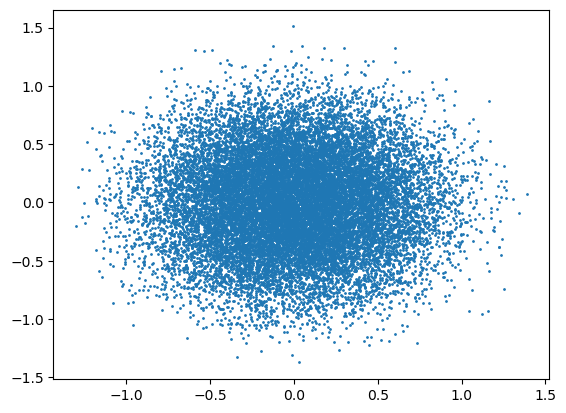

In [192]:
plt.figure()
plt.scatter(z[:,:,0],z[:,:,1],s=1)
plt.show()

In [193]:
normal_dist = torch.distributions.Normal(loc=torch.zeros(DIM,1), scale=torch.ones(DIM,1))
DS=MY_Dataset(normal_dist,N_nod,epoch_size=2**14)
train_loader = DataLoader(DS, batch_size=2**12, shuffle=True)

In [194]:
class Pipeline(pl.LightningModule):
    def __init__(
        self,
        model,
        latent,
        criterion,
        optimizer_class=torch.optim.Adam,
        optimizer_kwargs={"lr": 0.001,"weight_decay": 0}
    ) -> None:
        super().__init__()
        self.model = model
        self.loss = criterion
        self.latent = latent
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs

    """
    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        return optimizer
    """
    
    def configure_optimizers(self):
        optimizer = self.optimizer_class(self.model.parameters(), **self.optimizer_kwargs)
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer,
            min_lr=1e-4,
            factor=0.95,
            mode="min",
            verbose=True,
        )

        lr_scheduler = {
            "scheduler": scheduler,
            "interval": "epoch",
            "monitor": "train_loss",
        }
        return [optimizer], [lr_scheduler]

    def training_step(self, batch, batch_idx):
        z = batch
        latent_log_prob = torch.sum(self.latent.log_prob(z),(1,2))
        
        x, log_abs_det = self.model.g(z)
        x = torch.reshape(x,(x.size(0),1,x.size(1)))
        loss = self.loss(x,log_abs_det)
        ess = self.loss.ESS(latent_log_prob,log_abs_det)

        
        sch = self.lr_schedulers()
        sch.step(loss)
        self.log('train_loss', loss,prog_bar=True)
        self.log('ess',ess)
        self.log('lr',sch.get_last_lr()[0])
        return loss


    def on_train_epoch_end(self):
        #print("---------------------------end epoch---------------------------------")
        pass
    
    def on_validation_end(self) -> None:
        if not self.automatic_optimization:
            # Save a checkpoint of the model
            ckpt_path = os.path.join(self.trainer.log_dir, 'checkpoints', 'ckpt.pt')
            self.trainer.save_checkpoint(ckpt_path, weights_only=True)
        return super().on_validation_end()
    
    

In [195]:
flows = NormalizingFlow.configure_flows(n_flows=6,num_hidden=6,hidden_dim=4*DIM,p_drop=0,dim=DIM,param_dim=0,mask_config = get_split_masks,sys_dim = 1)
nf = NormalizingFlow(flows)

In [196]:
set_random_seed(42)
pipeline=Pipeline(model=nf, latent = normal_dist ,criterion = pow.get_KL(), optimizer_class=torch.optim.Adam,optimizer_kwargs={"lr": 0.01,"weight_decay":0.0})

trainer = pl.Trainer(
    max_epochs = 2000,
    logger = TensorBoardLogger(save_dir=f"./logs/pot"),
    num_sanity_val_steps = 0,
    log_every_n_steps = 1,
    enable_checkpointing = False,
    accumulate_grad_batches = 1
)

trainer.fit(model=pipeline, train_dataloaders=train_loader)
torch.save(nf.state_dict(),"./weights/pow.pth")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type            | Params | Mode 
--------------------------------------------------
0 | model | NormalizingFlow | 164 K  | train
1 | loss  | KL_with_S       | 0      | train
--------------------------------------------------
164 K     Trainable params
0         Non-trainable params
164 K     Total params
0.656     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

In [205]:
flows = NormalizingFlow.configure_flows(n_flows=6,num_hidden=6,hidden_dim=4*DIM,p_drop=0,dim=DIM,param_dim=0,mask_config = get_split_masks,sys_dim = 1)
nf = NormalizingFlow(flows)
nf.load_state_dict(torch.load("./weights/pow.pth"))
nf.eval()
N_traj=50000
with torch.no_grad():
    x = normal_dist.sample((N_traj,))
    z,_ = nf.g(x)
    z = torch.reshape(z,(z.size(0),1,z.size(1)))
print(z.shape)

torch.Size([50000, 1, 16])


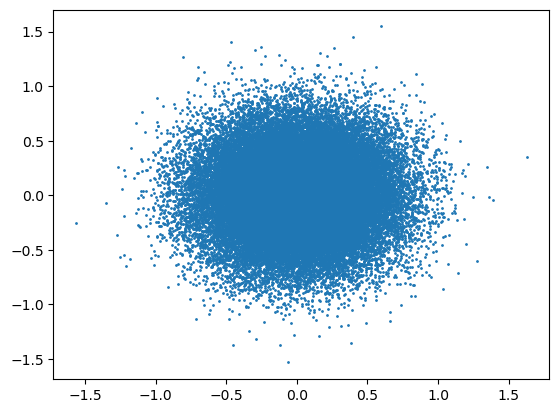

In [207]:
plt.figure()
plt.scatter(z[:,:,0],z[:,:,1],s=1)
plt.show()

In [209]:
hst = torch.histogram(z[:,:,0])

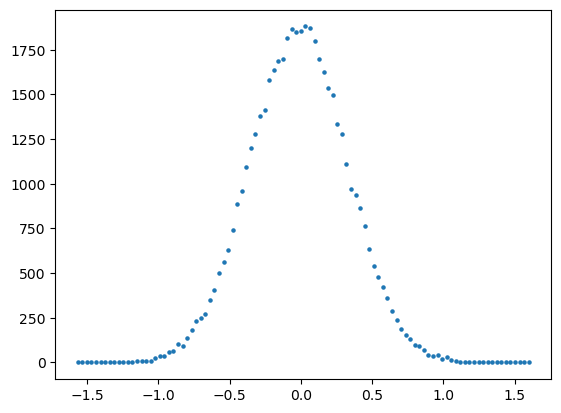

In [211]:
plt.figure()
plt.scatter(hst[1][:-1],hst[0],s=5)
plt.show()

In [215]:
from scipy.stats import kstest
Z=torch.flatten(z)
#Z = z[:,:,0].numpy()
Z=Z.numpy()
sigma = np.std(Z)
mu = np.mean(Z)
Z = (Z-mu)/sigma
kstest(Z,"norm")

KstestResult(statistic=0.0006407133965787848, pvalue=0.8975906664667885, statistic_location=0.16441295, statistic_sign=-1)

In [157]:
z=torch.rand(5000,)
print(z.shape)
Z = z.numpy()
sigma = np.std(Z)
mu = np.mean(Z)
Z = (Z-mu)/sigma
kstest(Z,"norm")

torch.Size([5000])


KstestResult(statistic=0.05570749675022568, pvalue=6.28934492481509e-14, statistic_location=-0.7820503, statistic_sign=1)